In [36]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf
print("tensorflow = {}".format(tf.__version__))
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

MODEL_NAME_KERAS = "densenet.keras"
MODEL_NAME_H5 = "densenet.h5"

BASE_MODEL_NAME_KERAS = "base_densenet.keras"
BASE_MODEL_NAME_H5 = "base_densenet.h5"


model_dir = './models/'
MODEL_FILE = model_dir + MODEL_NAME_KERAS
MODEL_FILE_H5 = model_dir + MODEL_NAME_H5

BASE_MODEL_FILE = model_dir + BASE_MODEL_NAME_KERAS
BASE_MODEL_FILE_H5 = model_dir + BASE_MODEL_NAME_H5

Keras = 2.15.0
tensorflow = 2.15.0
Num GPUs Available:  1


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
! unzip -o drive/MyDrive/dataset_19.zip
! unzip -o drive/MyDrive/Brain_MRI.zip

! pwd

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/Tr-gl_0732.jpg  
  inflating: Training/glioma/

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

## Data Distribution

In [38]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

meningioma    120
pituitary     120
notumor       120
glioma        120
dtype: int64

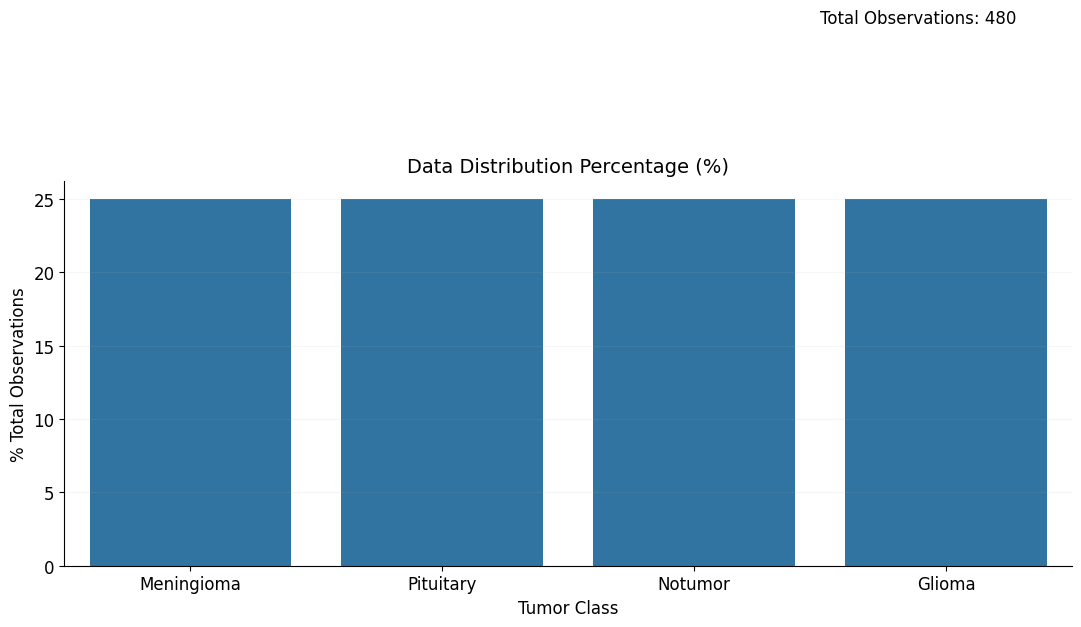

In [39]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data

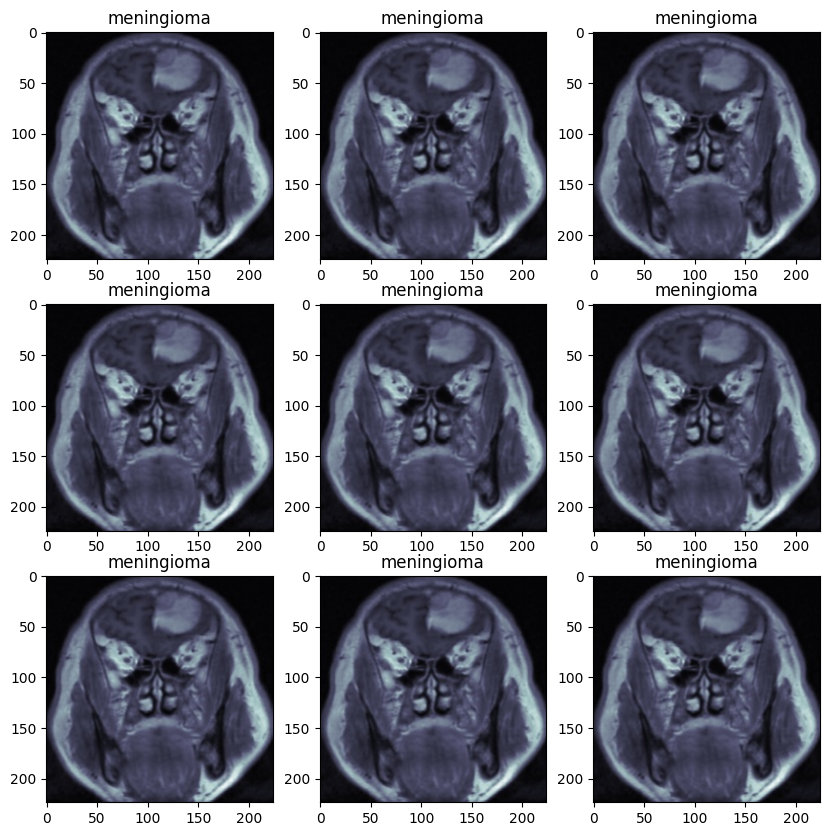

In [40]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

## Splitting the data

In [41]:
classes = os.listdir(dir)

batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle = False,
    subset='validation')


print(test_generator.class_indices)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [9]:
!pip install tensorflow-addons
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.1 MB/s eta 0:00:00


# Training a DenseNet121 model

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_10 (ZeroPad  (None, 230, 230, 3)          0         ['input_6[0][0]']             
 ding2D)                                                                                          
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_10[0][0]']   
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

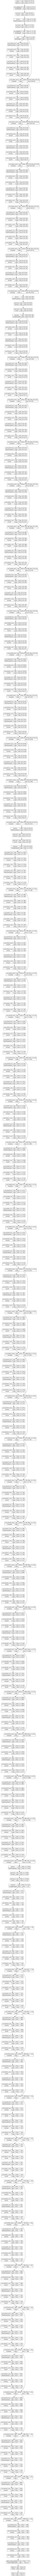

In [42]:
from keras.utils import plot_model
from keras.applications import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model
from keras.regularizers import l2
from tensorflow_addons.optimizers import RectifiedAdam
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import BatchNormalization



# Load the pre-trained DenseNet121 model, excluding the top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Exclude the bottom three layers (remove last 3 layers)
base_model_layers = base_model.layers[:-3]

# Create a new model with the remaining layers
x = base_model_layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

# Final dense layer with 4 neurons for classification
predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.01), dtype='float64')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with RectifiedAdam optimizer
optimizer = RectifiedAdam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])


# Summary of the model
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Train the model

In [ ]:
# import shutil
# from google.colab import files

# # Replace 'my_folder' with the name of your folder
# folder_name = 'models'

# # Create a zip file
# shutil.make_archive(folder_name, 'zip', folder_name)

# # Download the zip file
# files.download(f'{folder_name}.zip')

In [43]:

from keras.callbacks import *

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6)
checkpoint = ModelCheckpoint(MODEL_FILE, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=150,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the model
model.save(MODEL_FILE)
model.save(MODEL_FILE_H5)

Epoch 1/150
38/38 [==============================] - ETA: 0s - loss: 1.4551 - accuracy: 0.2594 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - categorical_accuracy: 0.2594
Epoch 1: val_loss improved from inf to 1.46131, saving model to ./models/densenet.keras
38/38 [==============================] - 44s 338ms/step - loss: 1.4551 - accuracy: 0.2594 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - categorical_accuracy: 0.2594 - val_loss: 1.4613 - val_accuracy: 0.1667 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_categorical_accuracy: 0.1667 - lr: 1.0000e-04
Epoch 2/150
38/38 [==============================] - ETA: 0s - loss: 1.4415 - accuracy: 0.4759 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - categorical_accuracy: 0.4759
Epoch 2: val_loss improved from 1.46131 to 1.44936, saving model to ./models/densenet.keras
38/38 [==============================] - 10s 271ms/step - loss: 1.4415 - accuracy: 0.4759 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - categori

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Testing the Model

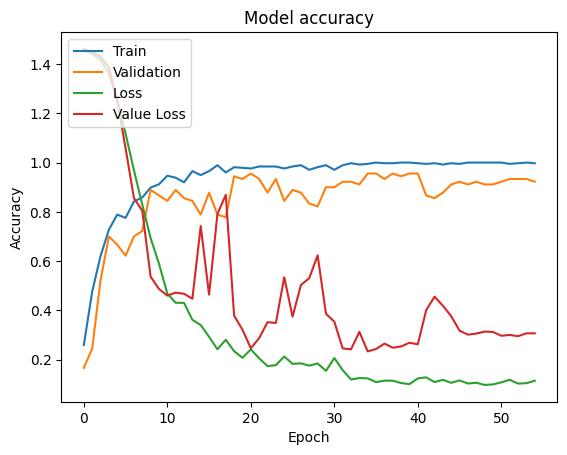

In [44]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [45]:
# Validate the model with test data

model = keras.models.load_model(MODEL_FILE)
validation_generator = test_generator


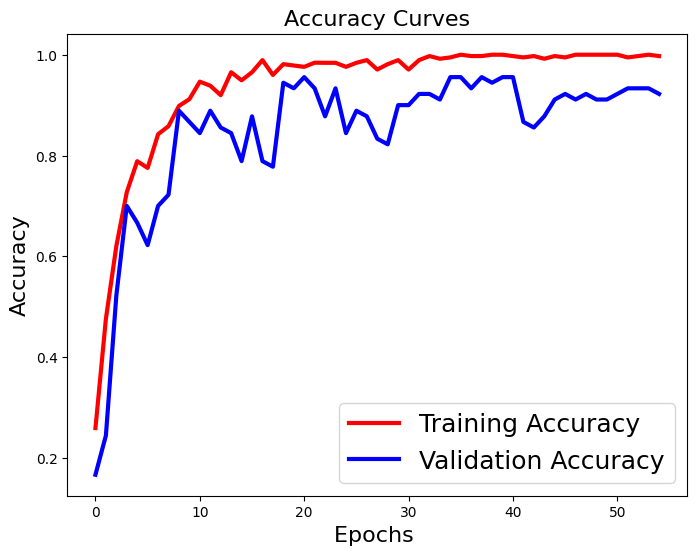

In [46]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)
plt.show()

# Model Visualisation (Evaluation)

10/10 [==============================] - 3s 54ms/step


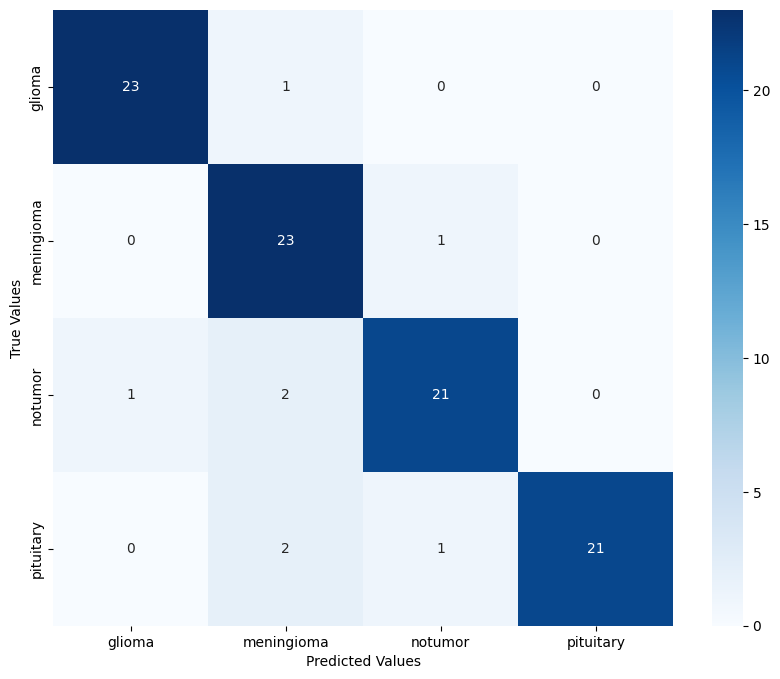

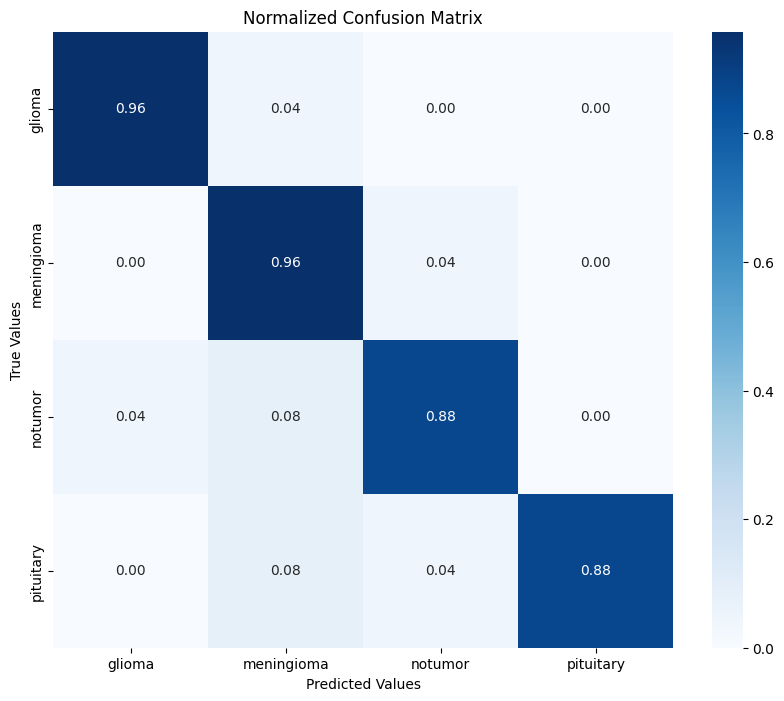

DSC: 0.9174747681396618, Sensitivity: 0.9166666666666667, Specificity: 0.9722222222222222, Accuracy: 0.9166666666666666


In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")


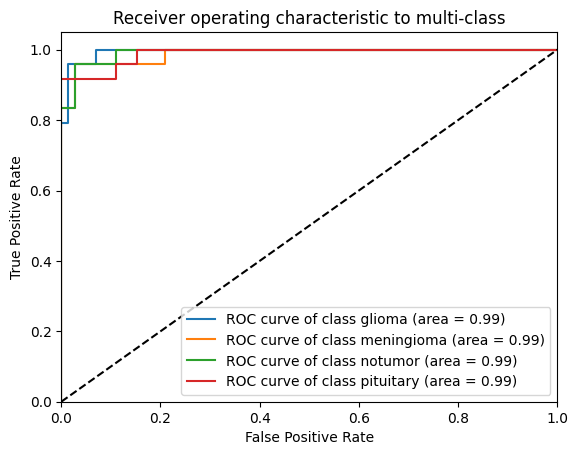

              precision    recall  f1-score   support

      glioma       0.96      0.96      0.96        24
  meningioma       0.82      0.96      0.88        24
     notumor       0.91      0.88      0.89        24
   pituitary       1.00      0.88      0.93        24

   micro avg       0.92      0.92      0.92        96
   macro avg       0.92      0.92      0.92        96
weighted avg       0.92      0.92      0.92        96
 samples avg       0.92      0.92      0.92        96



In [48]:

from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

In [49]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow_addons.optimizers import RectifiedAdam
from keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
from keras.models import Model

# Set parameters
dir = 'dataset_19'  # Update this to your dataset directory
batch_size = 10
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4
k = 5

# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05)

# List all images and labels
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Fold {fold + 1}/{k}')

    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionV3 model, include the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(224,224,3))

    # Exclude the bottom three layers (remove last 3 layers)
    base_model_layers = base_model.layers[:-3]

    # Create a new model with the remaining layers
    x = base_model_layers[-1].output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.055)(x)

    # Final dense layer with 4 neurons for classification
    predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.1), dtype='float64')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with RectifiedAdam optimizer
    optimizer = RectifiedAdam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])


    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=90,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')

Fold 1/5
Found 384 validated image filenames belonging to 4 classes.
Found 96 validated image filenames belonging to 4 classes.
87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/90
38/38 [==============================] - 33s 336ms/step - loss: 2.2515 - accuracy: 0.2807 - precision_6: 0.3482 - recall_6: 0.1043 - categorical_accuracy: 0.2807 - val_loss: 2.4358 - val_accuracy: 0.2556 - val_precision_6: 0.2742 - val_recall_6: 0.1889 - val_categorical_accuracy: 0.2556 - lr: 1.0000e-04
Epoch 2/90
38/38 [==============================] - 7s 179ms/step - loss: 2.1230 - accuracy: 0.3449 - precision_6: 0.5000 - recall_6: 0.0989 - categorical_accuracy: 0.3449 - val_loss: 2.2247 - val_accuracy: 0.3556 - val_precision_6: 0.4048 - val_recall_6: 0.1889 - val_categorical_accuracy: 0.3556 - lr: 1.0000e-04
Epoch 3/90
38/38 [==============================] - 9s 234ms/step - loss: 1.9467 - accuracy: 0.4866 - precision_6: 0.7500 - recall_6: 0.2086 - categorical_accuracy: 0.4866 - va

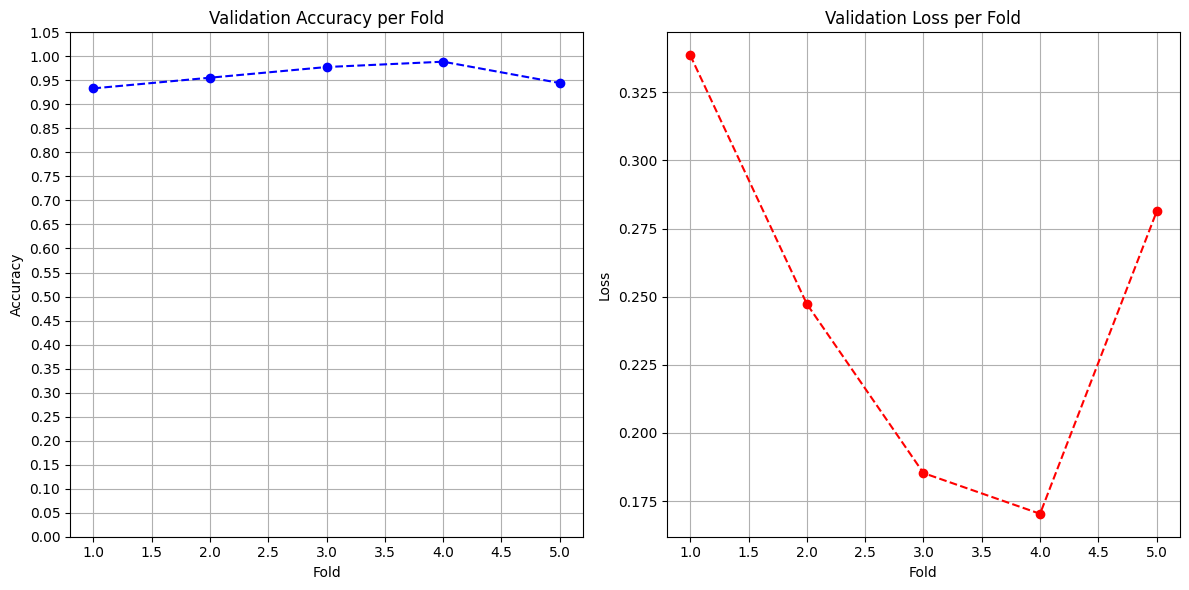

In [50]:

import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
import os
import optuna
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import Xception
from keras.utils import plot_model
from keras.regularizers import l2
from tensorflow_addons.optimizers import RectifiedAdam

classes = os.listdir(dir)

# Data generator setup
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05, # newly added
    height_shift_range=0.05, # newly added
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

# Model creation function modified for Optuna
def create_model(input_shape, num_classes, trial):
    # Suggest hyperparameters
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.05, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224,224,3))
    base_model_layers = base_model.layers[:-3]

    x = base_model_layers[-1].output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)

    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.1), dtype='float64')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = RectifiedAdam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])

    return model

# Objective function for Optuna
def objective(trial):
    # Get suggested batch size
    batch_size = 10

    train_generator = train_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        subset='training'
    )

    test_generator = validation_datagen.flow_from_directory(
        dir,
        target_size=(224, 224),
        batch_size=batch_size,
        seed=42,
        subset='validation'
    )

    model = create_model((224, 224, 3), len(classes), trial)
    checkpoint = ModelCheckpoint(MODEL_FILE, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        epochs=100,
        callbacks=[checkpoint, early_stopping]
    )

    # Load the best weights before returning the final validation loss
    model.load_weights(MODEL_FILE)

    # Store the training history in the trial
    trial.set_user_attr('history', history.history)

    # Evaluate the model with the best weights on the validation set
    val_loss = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)[0]

    return val_loss

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

history = trial.user_attrs['history']

[I 2024-06-13 06:36:59,271] A new study created in memory with name: no-name-4d91e417-4a76-418e-a8ed-8e6fe8c91e6f


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.


<ipython-input-51-e9b18c1c07ef>:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.05, 0.5)
<ipython-input-51-e9b18c1c07ef>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


83683744/83683744 [==============================] - 5s 0us/step
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.0812 - accuracy: 0.4786 - precision_11: 1.0000 - recall_11: 0.0080 - categorical_accuracy: 0.4786
Epoch 1: val_loss improved from inf to 2.04068, saving model to ./models/densenet.keras
38/38 [==============================] - 27s 305ms/step - loss: 2.0812 - accuracy: 0.4786 - precision_11: 1.0000 - recall_11: 0.0080 - categorical_accuracy: 0.4786 - val_loss: 2.0407 - val_accuracy: 0.4556 - val_precision_11: 0.0000e+00 - val_recall_11: 0.0000e+00 - val_categorical_accuracy: 0.4556
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.5177 - accuracy: 0.7834 - precision_11: 0.9253 - recall_11: 0.4305 - categorical_accuracy: 0.7834
Epoch 2: val_loss improved from 2.04068 to 1.64253, saving model to ./models/densenet.keras
38/38 [==============================] - 9s 242ms/step - loss: 1.5177 - accuracy: 0.7834 - precision_11: 0.9253 - rec

[I 2024-06-13 06:42:47,517] Trial 0 finished with value: 0.3104654848575592 and parameters: {'dropout_rate': 0.11475162610569759, 'learning_rate': 0.0005849130056922954}. Best is trial 0 with value: 0.3104654848575592.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1965 - accuracy: 0.2059 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - categorical_accuracy: 0.2059
Epoch 1: val_loss improved from inf to 2.19612, saving model to ./models/densenet.keras
38/38 [==============================] - 25s 263ms/step - loss: 2.1965 - accuracy: 0.2059 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - categorical_accuracy: 0.2059 - val_loss: 2.1961 - val_accuracy: 0.1667 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - val_categorical_accuracy: 0.1667
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.1756 - accuracy: 0.2914 - precision_12: 0.0000e+00 - recall_12: 0.0000e+00 - categorical_accuracy: 0.2914
Epoch 2: val_loss did not improve from 2.19612
38/38 [==============================] - 8s 205ms/step - loss: 2.1756 - accuracy: 0.2914 - precision_12: 0.0000e+00 - reca

[I 2024-06-13 06:58:23,056] Trial 1 finished with value: 0.9094094038009644 and parameters: {'dropout_rate': 0.0885540575126719, 'learning_rate': 1.4399607625965069e-05}. Best is trial 0 with value: 0.3104654848575592.


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1569 - accuracy: 0.3369 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - categorical_accuracy: 0.3369
Epoch 1: val_loss improved from inf to 2.14217, saving model to ./models/densenet.keras
38/38 [==============================] - 21s 236ms/step - loss: 2.1569 - accuracy: 0.3369 - precision_13: 0.0000e+00 - recall_13: 0.0000e+00 - categorical_accuracy: 0.3369 - val_loss: 2.1422 - val_accuracy: 0.2778 - val_precision_13: 0.0000e+00 - val_recall_13: 0.0000e+00 - val_categorical_accuracy: 0.2778
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.9653 - accuracy: 0.5535 - precision_13: 0.8889 - recall_13: 0.0214 - categorical_accuracy: 0.5535
Epoch 2: val_loss improved from 2.14217 to 2.01380, saving model to ./models/densenet.keras
38/38 [==============================] - 10s 249ms/step - loss: 1.9653 - accuracy: 0.